tm = 시간 (신고접수 날짜)  
address_city = 시/도명  
address_gu = 군/구명  
sub_address = 읍/면/동명  
stn = AWS 지점 코드  
ta_min = 최저기온 (일 최저기온)  
ta_max = 최고기온 (일 최고기온)  
ta_max_min = 일교차 (일 최고기온과 최저기온의 차)  
m_day = 일강수량 (0~24시까지의 일 강수량)  
ws_ins_max = 최대 순간 풍속 (일 최대 순간 풍속)  
ws_max = 최대 풍속 (일 최대 10분 평균 풍속)  
  
cat = 신고종류  
sub_cat = 신고 세부종류  
call_count = 신고건수 (일 신고건수)  

In [81]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# csv 읽기
call_df = pd.read_csv("call119_train.csv", index_col=0)
cat_df = pd.read_csv("cat119_train.csv", index_col=0)

# 컬럼명 간단히 변경
call_df = call_df.rename(columns={
    'call119_train.tm': 'tm',
    'call119_train.address_city': 'city',
    'call119_train.address_gu': 'gu',
    'call119_train.sub_address': 'dong',
    'call119_train.stn': 'stn',
    'call119_train.ta_max': 'ta_max',
    'call119_train.ta_min': 'ta_min',
    'call119_train.ta_max_min': 'ta_max_min',
    'call119_train.hm_min': 'hm_min',
    'call119_train.hm_max': 'hm_max',
    'call119_train.ws_max': 'ws_max',
    'call119_train.ws_ins_max': 'ws_ins_max',
    'call119_train.rn_day': 'rn_day',
    'call119_train.call_count': 'call_total'
})

cat_df = cat_df.rename(columns={
    'cat119_train.tm': 'tm',
    'cat119_train.address_city': 'city',
    'cat119_train.address_gu': 'gu',
    'cat119_train.sub_address': 'dong',
    'cat119_train.cat': 'cat',
    'cat119_train.sub_cat': 'sub_cat',
    'cat119_train.stn': 'stn',
    'cat119_train.call_count': 'call_cat_sum'
})

In [82]:
# 전처리
# 숫자형 변환 (기상 변수)
for col in ['ta_max', 'ta_min', 'ta_max_min', 'hm_min', 'hm_max', 'ws_max', 'ws_ins_max', 'rn_day']:
    call_df[col] = pd.to_numeric(call_df[col], errors='coerce')

# 결측치 제거
call_df = call_df.dropna(subset=['ta_max', 'ta_min', 'ta_max_min', 'hm_min', 'hm_max', 'ws_max', 'ws_ins_max', 'rn_day', 'call_total'])
cat_df = cat_df.dropna(subset=['call_cat_sum'])

In [83]:
# 두 데이터프레임 병합 (키: tm, city, gu, dong, stn)
merged_df = pd.merge(call_df, cat_df, on=['tm', 'city', 'gu', 'dong', 'stn'], how='left')

# 결측치 0으로 채우기 (cat 관련)
merged_df['call_cat_sum'] = merged_df['call_cat_sum'].fillna(0)

# 범주형 변수 리스트
cat_features = ['city', 'gu', 'dong', 'cat', 'sub_cat']

# Label Encoding
for col in cat_features:
    le = LabelEncoder()
    # 결측 처리 후 인코딩
    merged_df[col] = merged_df[col].fillna('unknown')
    merged_df[col] = le.fit_transform(merged_df[col])

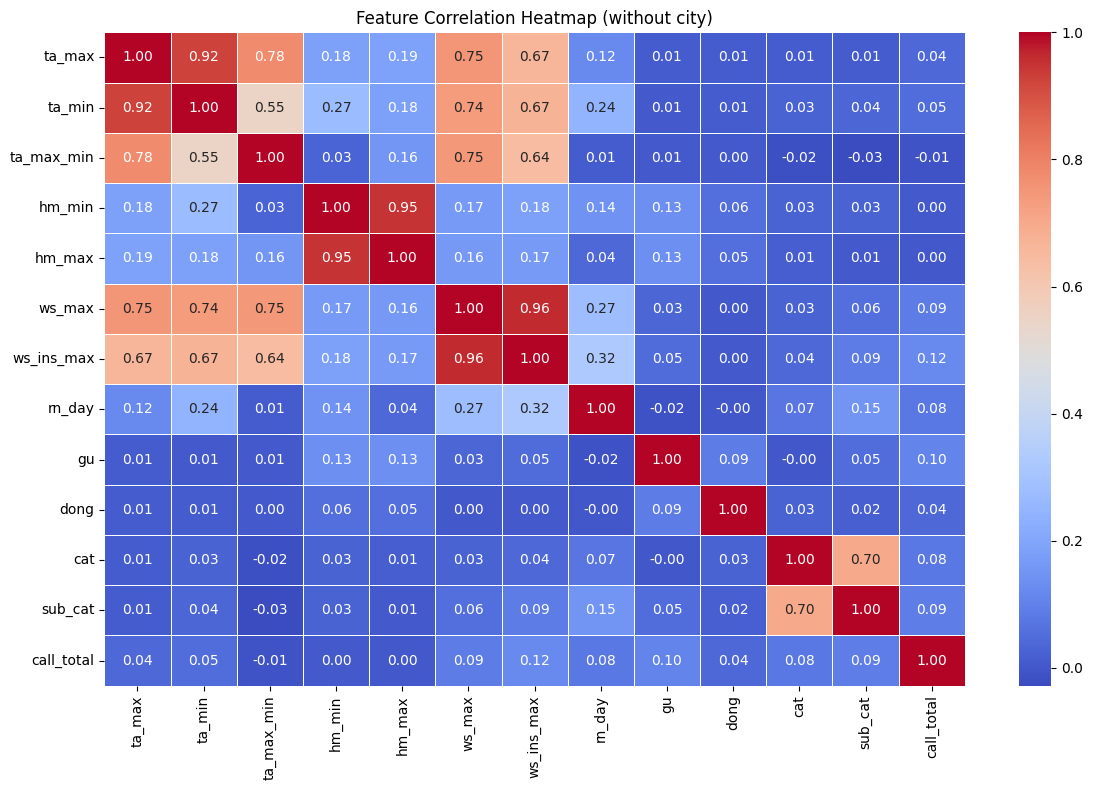

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

excluded = ['city']  # 제외할 컬럼
corr_cols = [col for col in features + [target] if col not in excluded]
corr = merged_df[corr_cols].corr()

# 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap (without city)')
plt.tight_layout()
plt.show()

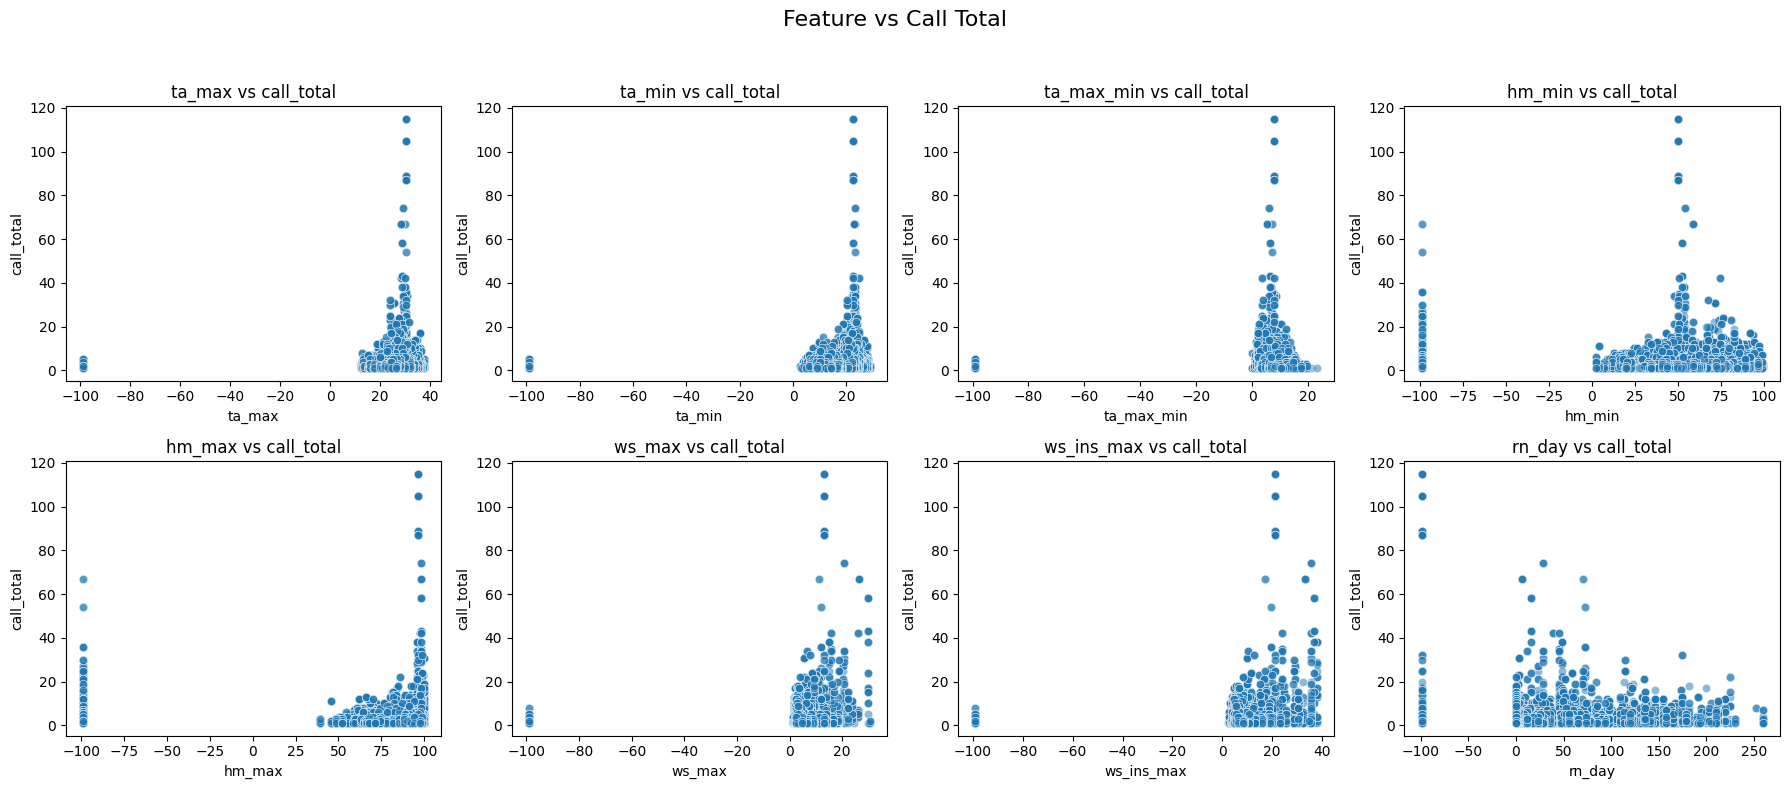

In [85]:
num_cols = ['ta_max', 'ta_min', 'ta_max_min', 'hm_min', 'hm_max', 'ws_max', 'ws_ins_max', 'rn_day']

# 2x4 서브플롯
fig, axs = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle('Feature vs Call Total', fontsize=16)

for i, col in enumerate(num_cols):
    ax = axs[i//4, i%4]
    sns.scatterplot(data=merged_df, x=col, y=target, alpha=0.5, ax=ax)
    ax.set_title(f'{col} vs call_total')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [87]:
# 모델학습
# feature, target 정의
features = ['ta_max', 'ta_min', 'ta_max_min', 'hm_min', 'hm_max', 'ws_max', 'ws_ins_max', 'rn_day'] + cat_features
target = 'call_total'

X = merged_df[features]
y = merged_df[target]

# 데이터 분할 (간단하게 8:2)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# city 제거
X_train = X_train.drop(columns=['city'])
X_val = X_val.drop(columns=['city'])

# XGBoost 모델 학습
model = XGBRegressor(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=200,
    subsample=0.7,
    random_state=42
)
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

RMSE: 1.4468
R2 Score: 0.7813
